In [1]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display

In [2]:
class MelDataset(Dataset):
    def __init__(self, wav_dir, sr=44100, n_mels=128, duration=5.0, hop_length=256, preload=True):
        self.files = [os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith('.wav')]
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.hop_length = hop_length
        self.n_samples = int(sr * duration)
        self.preload = preload

        if self.preload:
            print(f"🔁 Preloading {len(self.files)} audio files into memory...")
            self.cache = [self.process_file(f) for f in self.files]
        else:
            self.cache = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.cache[idx] if self.preload else self.process_file(self.files[idx])

    def process_file(self, path):
        y, _ = librosa.load(path, sr=self.sr)
        n_samples = self.n_samples

        # === ✅ Apply pre-emphasis
        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # === Trim or pad
        if len(y) > n_samples:
            start = np.random.randint(0, len(y) - n_samples)
            y = y[start:start + n_samples]
        else:
            y = np.pad(y, (0, n_samples - len(y)), mode='constant')

        # === Mel computation
        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=self.hop_length)
        mel_db = librosa.power_to_db(mel, ref=np.max).T  # [T, n_mels]

        # === Pad/truncate to fixed length
        T_target = int(np.ceil(self.duration * self.sr / self.hop_length))
        if mel_db.shape[0] < T_target:
            pad_len = T_target - mel_db.shape[0]
            mel_db = np.pad(mel_db, ((0, pad_len), (0, 0)), mode='constant')
        else:
            mel_db = mel_db[:T_target]

        # === Normalize to [-1, 1]
        mel_db = (mel_db + 80.0) / 80.0
        mel_db = mel_db * 2.0 - 1.0
        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0).transpose(1, 2)  # [1, 128, T]
        return mel_tensor



In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(dropout),  # 🔥 dropout inserted here
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.relu(x + self.block(x))

class DilatedTemporalConv1D(nn.Module):
    def __init__(self, channels, dilation_rates=(1, 2, 4)):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(channels, channels, kernel_size=(1, 3), padding=(0, d), dilation=(1, d))
            for d in dilation_rates
        ])
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        out = x
        for conv in self.layers:
            out = self.act(conv(out)) + out  # residual
        return out
    
class LightConvBlock(nn.Module):
    def __init__(self, channels, kernel_size=5):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(
            channels, channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2),
            groups=channels  # depthwise
        )
        self.pointwise = nn.Conv2d(channels, channels, kernel_size=1)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.act(self.pointwise(self.depthwise_conv(x))) + x



class LightSkipDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res1 = ResidualBlock(256)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res2 = ResidualBlock(128)

        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.skip_proj1 = nn.Conv2d(128, 64, kernel_size=1)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res3 = ResidualBlock(64)

        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.skip_proj2 = nn.Conv2d(128, 32, kernel_size=1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res4 = ResidualBlock(32)

        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1)
        )
        self.res5 = ResidualBlock(16)
        self.res6 = ResidualBlock(16)

        self.temporal_dilated = DilatedTemporalConv1D(16)
        self.lightconv = LightConvBlock(16)

        self.out_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(1, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.up1(x)
        x = self.conv1(x)
        x = self.res1(x)

        x = self.up2(x)
        x1 = self.conv2(x)
        x = self.res2(x1)

        x = self.up3(x)
        skip1 = F.interpolate(self.skip_proj1(x1), size=x.shape[-2:], mode='nearest')
        x = torch.cat([x, skip1], dim=1)
        x = self.conv3(x)
        x = self.res3(x)

        x = self.up4(x)
        skip2 = F.interpolate(self.skip_proj2(x1), size=x.shape[-2:], mode='nearest')
        x = torch.cat([x, skip2], dim=1)
        x = self.conv4(x)
        x = self.res4(x)

        x = self.up5(x)
        x = self.conv5(x)
        x = self.res5(x)
        x = self.res6(x)
        x = self.temporal_dilated(x)
        x = self.lightconv(x)

        x = F.interpolate(x, size=(128, 862), mode='nearest')
        x = self.out_conv(x)
        return x


class VAE(nn.Module):
    def __init__(self, input_dim=(128, 862), latent_dim=512):
        super().__init__()
        c, t = input_dim

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(self.encoder_conv, self.flatten)

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, c, t)
            features = self.encoder_conv(dummy_input)
            self.decoder_shape = features.shape[1:]
            self.enc_out_dim = features.view(1, -1).size(1)
            print(f"decoder_shape: {self.decoder_shape} → flattened: {self.enc_out_dim}")

        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.enc_out_dim)
        self.decode_dropout = nn.Dropout(p=0.3)  # <-- added dropout

        self.decoder = LightSkipDecoder()

        # Weight init
        for m in self.decoder.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        for m in self.encoder_conv.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decode_dropout(self.fc_decode(z))  # <-- apply dropout here
        h = h.view(z.size(0), *self.decoder_shape)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [4]:
# === Temporal + spectral smoothing
def smoothing_loss(x, alpha=1.0, beta=0.5):
    dt = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()
    df = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()
    return alpha * dt + beta * df

# === Multi-scale temporal pooling
def multi_scale_loss(x_recon, x):
    loss = 0.0
    for scale in [2, 4, 8]:
        recon_down = F.avg_pool2d(x_recon, kernel_size=(1, scale))
        x_down = F.avg_pool2d(x, kernel_size=(1, scale))
        loss += F.l1_loss(recon_down, x_down)
    return loss

# === Frequency-bin weighted L1
def frequency_weighted_l1(x_recon, x, min_weight=0.5, max_weight=2.0):
    B, C, F, T = x.shape
    weights = torch.linspace(min_weight, max_weight, F, device=x.device).view(1, 1, F, 1)
    return (weights * torch.abs(x - x_recon)).mean()

# === Multi-band loss (low/mid/high)
def multi_band_l1(x_recon, x, band_splits=(32, 64), weights=[0.5, 2.0, 1.5]):
    total = 0.0
    start = 0
    for i, end in enumerate(list(band_splits) + [128]):
        total += weights[i] * F.l1_loss(x[:, :, start:end], x_recon[:, :, start:end])
        start = end
    return total


# === Cosine spectral contrast loss
def spectral_contrast_loss(x_recon, x, sr=44100, n_fft=1024, hop_length=256):
    B = x.shape[0]
    total_loss = 0.0
    for i in range(B):
        # Unnormalize to log-dB
        mel_true = ((x[i, 0].cpu().numpy() + 1) / 2) * 80.0 - 80.0
        mel_recon = ((x_recon[i, 0].detach().cpu().numpy() + 1) / 2) * 80.0 - 80.0

        S_true = librosa.db_to_power(mel_true)
        S_recon = librosa.db_to_power(mel_recon)

        contrast_true = librosa.feature.spectral_contrast(
            S=S_true, sr=sr, n_fft=n_fft, hop_length=hop_length
        )
        contrast_recon = librosa.feature.spectral_contrast(
            S=S_recon, sr=sr, n_fft=n_fft, hop_length=hop_length
        )

        sims = [
            np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-6)
            for a, b in zip(contrast_true, contrast_recon)
        ]
        loss = 1.0 - np.mean(sims)
        total_loss += loss

    return torch.tensor(total_loss / B, dtype=torch.float32, requires_grad=True).to(
        x.device
    )


# === Log-dB perceptual loss
def perceptual_l1(x_recon, x, eps=1e-4):
    x_recon = (x_recon + 1) / 2  # → [0, 1]
    x = (x + 1) / 2
    x_recon = torch.clamp(x_recon, min=eps)
    x = torch.clamp(x, min=eps)
    return F.l1_loss(torch.log(x_recon), torch.log(x))


# === Local mu vs z reconstruction divergence
def local_latent_delta(x_recon, mu, model):
    with torch.no_grad():
        x_mu = model.decode(mu)
    return F.l1_loss(x_recon, x_mu)


# === VAE Loss
def vae_loss(
    x_recon,
    x,
    mu,
    logvar,
    model,
    beta=1.0,
    free_bits=0.01,
    lambda_smooth=0.1,
    lambda_multiscale=0.1,
    lambda_contrast=0.0,
):
    # Match dimensions
    min_T = min(x.shape[-1], x_recon.shape[-1])
    x, x_recon = x[..., :min_T], x_recon[..., :min_T]

    # Clamp to match decoder scale
    x = torch.clamp(x, min=-1.0, max=1.0)
    x_recon = torch.clamp(x_recon, min=-1.0, max=1.0)

    # === Core loss terms
    recon_loss = multi_band_l1(x_recon, x)
    perceptual_loss = perceptual_l1(x_recon, x)
    contrast = (
        spectral_contrast_loss(x_recon, x)
        if lambda_contrast > 0
        else torch.tensor(0.0, device=x.device)
    )

    # === KL Divergence (free bits trick)
    logvar = torch.clamp(logvar, min=-10, max=10)
    mu = torch.clamp(mu, min=-5.0, max=5.0)
    kl = -0.5 * (1 + logvar - mu**2 - logvar.exp())
    kl = torch.clamp(kl, min=free_bits)
    kl_loss = kl.sum(dim=1).mean()

    # === Regularizers
    smooth = smoothing_loss(x_recon - x)
    ms = multi_scale_loss(x_recon, x)
    latent_var_reg = torch.mean(torch.exp(logvar))
    delta_reg = local_latent_delta(x_recon, mu, model)

    loss = (
        recon_loss
        + 0.3 * perceptual_loss
        + beta * kl_loss
        + lambda_contrast * contrast
        + lambda_smooth * smooth
        + lambda_multiscale * ms
        + 0.01 * latent_var_reg
        + 0.01 * delta_reg
    )

    return loss, recon_loss, kl_loss, smooth, ms, contrast

In [5]:
dataset = MelDataset(
    wav_dir="data",
    sr=44100,
    n_mels=128,
    duration=5.0,       # fixed 5-second chunks
    hop_length=256,     # make sure this matches your spec generation
    preload=True
)


train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=32  # or 0 for debugging
    # No collate_fn needed anymore if all are same T
)



🔁 Preloading 1000 audio files into memory...


In [6]:
def plot_contrast_maps(mel_orig_norm, mel_recon_norm, sr=44100, hop_length=256, n_fft=1024, n_mels=128):

    # Step 1: De-normalize from [-1, 1] → dB → power
    mel_orig_db = ((mel_orig_norm + 1) / 2.0) * 80.0 - 80.0
    mel_recon_db = ((mel_recon_norm + 1) / 2.0) * 80.0 - 80.0

    mel_orig_power = librosa.db_to_power(mel_orig_db)
    mel_recon_power = librosa.db_to_power(mel_recon_db)

    # Step 2: Approximate inversion of mel to linear frequency
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    inv_mel = np.linalg.pinv(mel_basis)

    spec_orig = np.dot(inv_mel, mel_orig_power)
    spec_recon = np.dot(inv_mel, mel_recon_power)

    # Step 3: Compute spectral contrast
    contrast_orig = librosa.feature.spectral_contrast(S=spec_orig, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast_recon = librosa.feature.spectral_contrast(S=spec_recon, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Step 4: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    im1 = axs[0].imshow(contrast_orig, origin='lower', aspect='auto', cmap='viridis')
    axs[0].set_title("Original Spectral Contrast")
    fig.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(contrast_recon, origin='lower', aspect='auto', cmap='viridis')
    axs[1].set_title("Reconstructed Spectral Contrast")
    fig.colorbar(im2, ax=axs[1])

    plt.tight_layout()
    plt.show()


Input mel shape: 128 x 862
🚀 Using device: cuda
decoder_shape: torch.Size([512, 4, 26]) → flattened: 53248
Epoch 01 | Loss=4.0165 | Recon=2.7982 | KL=39.7744 | z.std=0.9999 | Beta=0.001 | Smooth=0.2938 | MS=2.1462 | Contrast=0.5325
Epoch 02 | Loss=3.0378 | Recon=1.9422 | KL=86.3557 | z.std=0.9999 | Beta=0.001 | Smooth=0.2482 | MS=1.4002 | Contrast=0.5278
Epoch 03 | Loss=2.7055 | Recon=1.6968 | KL=70.9056 | z.std=0.9999 | Beta=0.001 | Smooth=0.1808 | MS=1.2412 | Contrast=0.5669
Epoch 04 | Loss=2.5962 | Recon=1.6159 | KL=65.0258 | z.std=0.9999 | Beta=0.001 | Smooth=0.1624 | MS=1.1939 | Contrast=0.5857
Epoch 05 | Loss=2.5185 | Recon=1.5554 | KL=63.6229 | z.std=1.0000 | Beta=0.001 | Smooth=0.1519 | MS=1.1579 | Contrast=0.5870
Epoch 06 | Loss=2.4412 | Recon=1.4909 | KL=67.1722 | z.std=0.9999 | Beta=0.001 | Smooth=0.1433 | MS=1.1155 | Contrast=0.5700
Epoch 07 | Loss=2.3417 | Recon=1.4087 | KL=67.3756 | z.std=0.9999 | Beta=0.001 | Smooth=0.1352 | MS=1.0616 | Contrast=0.5398
Epoch 08 | Loss=2.

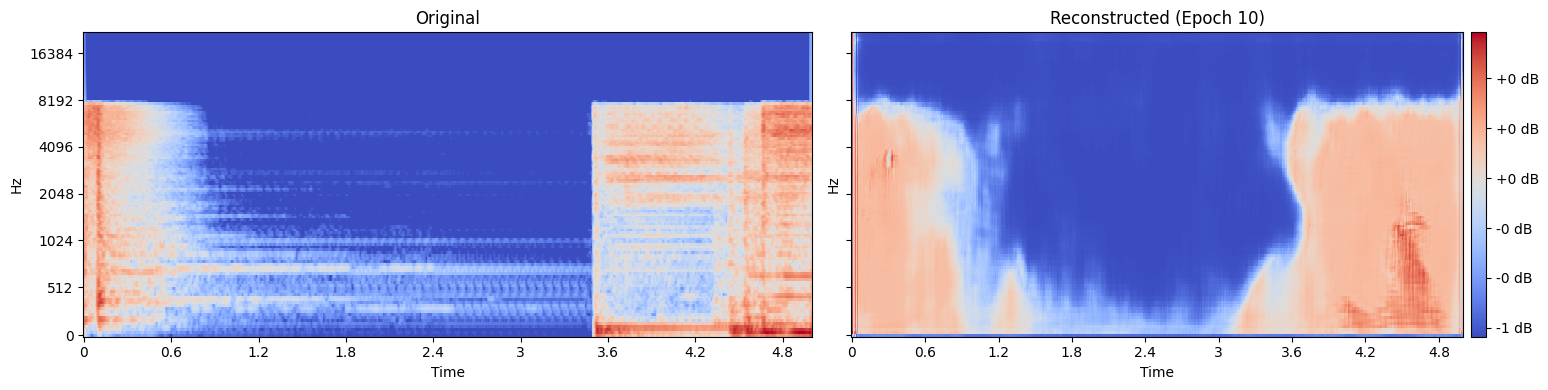

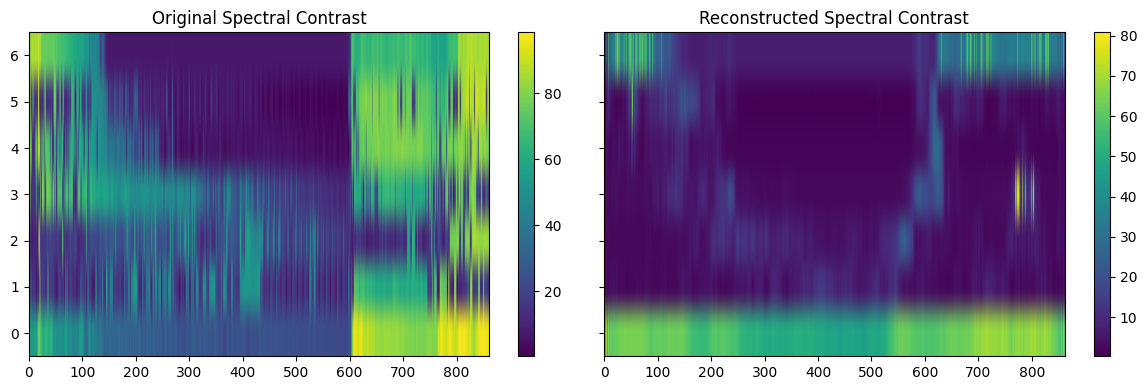

Epoch 11 | Loss=2.7769 | Recon=1.4805 | KL=8.5309 | z.std=1.0000 | Beta=0.050 | Smooth=0.1235 | MS=1.1109 | Contrast=0.5189
Epoch 12 | Loss=2.5794 | Recon=1.3922 | KL=6.6587 | z.std=0.9999 | Beta=0.050 | Smooth=0.1170 | MS=1.0512 | Contrast=0.5180
Epoch 13 | Loss=2.5258 | Recon=1.3548 | KL=6.4644 | z.std=1.0001 | Beta=0.050 | Smooth=0.1131 | MS=1.0276 | Contrast=0.5273
Epoch 14 | Loss=2.4925 | Recon=1.3255 | KL=6.4967 | z.std=1.0000 | Beta=0.050 | Smooth=0.1115 | MS=1.0063 | Contrast=0.5243
Epoch 15 | Loss=2.4595 | Recon=1.3044 | KL=6.3414 | z.std=1.0000 | Beta=0.050 | Smooth=0.1096 | MS=0.9920 | Contrast=0.5263
Epoch 16 | Loss=2.4576 | Recon=1.3042 | KL=6.3380 | z.std=1.0000 | Beta=0.050 | Smooth=0.1082 | MS=0.9906 | Contrast=0.5234
Epoch 17 | Loss=2.4296 | Recon=1.2833 | KL=6.2538 | z.std=1.0000 | Beta=0.050 | Smooth=0.1074 | MS=0.9782 | Contrast=0.5240
Epoch 18 | Loss=2.4205 | Recon=1.2766 | KL=6.2529 | z.std=1.0000 | Beta=0.050 | Smooth=0.1064 | MS=0.9714 | Contrast=0.5162
Epoch 19

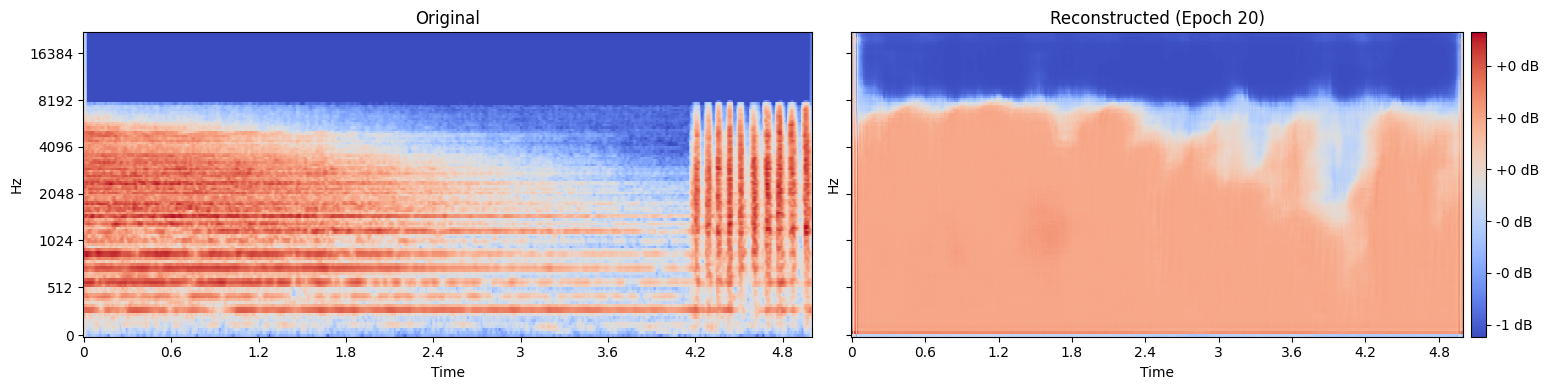

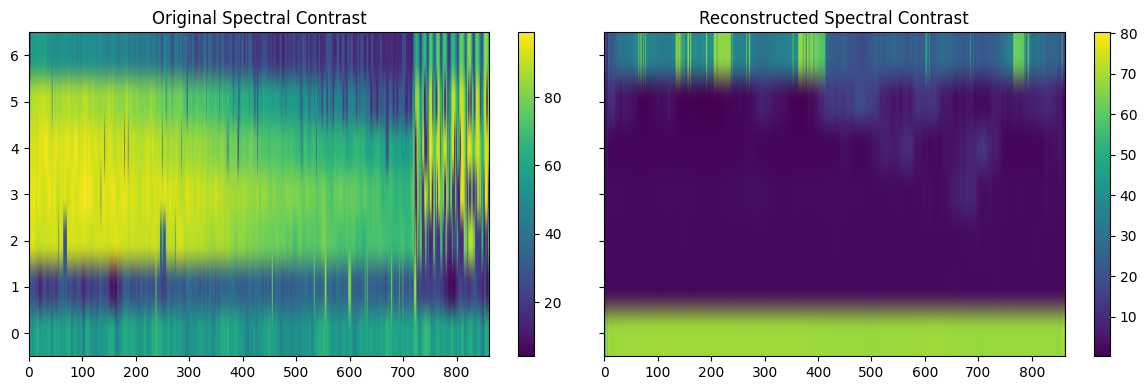

Epoch 21 | Loss=3.1944 | Recon=1.2968 | KL=5.3302 | z.std=1.0000 | Beta=0.200 | Smooth=0.1048 | MS=0.9803 | Contrast=0.5115
Epoch 22 | Loss=3.1841 | Recon=1.2969 | KL=5.2812 | z.std=0.9999 | Beta=0.200 | Smooth=0.1042 | MS=0.9803 | Contrast=0.5080
Epoch 23 | Loss=3.1658 | Recon=1.2843 | KL=5.2644 | z.std=1.0000 | Beta=0.200 | Smooth=0.1036 | MS=0.9725 | Contrast=0.5042
Epoch 24 | Loss=3.1543 | Recon=1.2752 | KL=5.2630 | z.std=1.0000 | Beta=0.200 | Smooth=0.1030 | MS=0.9649 | Contrast=0.4970
Epoch 25 | Loss=3.1332 | Recon=1.2587 | KL=5.2548 | z.std=1.0000 | Beta=0.200 | Smooth=0.1026 | MS=0.9548 | Contrast=0.4918
Epoch 26 | Loss=3.1223 | Recon=1.2520 | KL=5.2394 | z.std=1.0000 | Beta=0.200 | Smooth=0.1025 | MS=0.9504 | Contrast=0.4891
Epoch 27 | Loss=3.1029 | Recon=1.2346 | KL=5.2451 | z.std=1.0000 | Beta=0.200 | Smooth=0.1020 | MS=0.9394 | Contrast=0.4855
Epoch 28 | Loss=3.1072 | Recon=1.2413 | KL=5.2329 | z.std=1.0000 | Beta=0.200 | Smooth=0.1018 | MS=0.9425 | Contrast=0.4775
Epoch 29

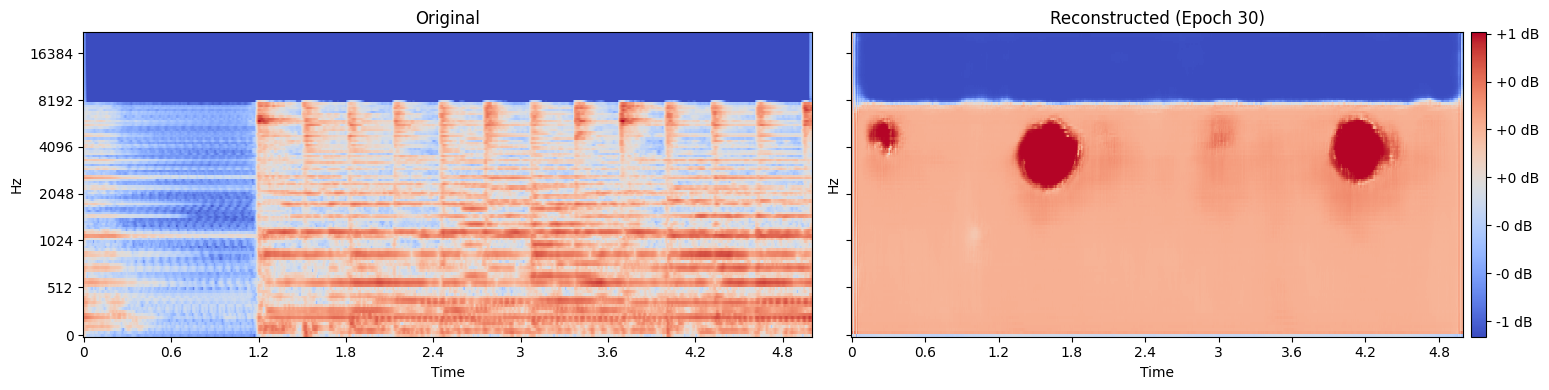

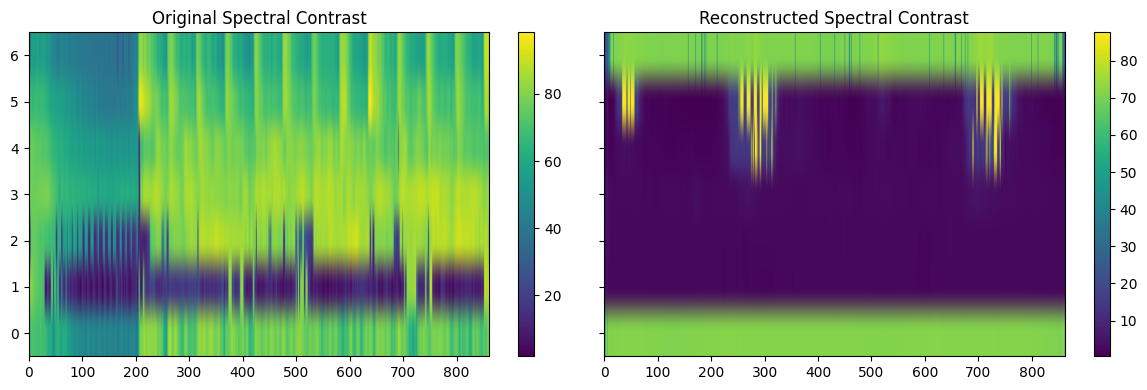

Epoch 31 | Loss=4.6374 | Recon=1.2400 | KL=5.1593 | z.std=1.0000 | Beta=0.500 | Smooth=0.1012 | MS=0.9421 | Contrast=0.4748
Epoch 32 | Loss=4.7423 | Recon=1.2256 | KL=5.1485 | z.std=0.9999 | Beta=0.525 | Smooth=0.1011 | MS=0.9323 | Contrast=0.4691
Epoch 33 | Loss=4.8633 | Recon=1.2212 | KL=5.1488 | z.std=1.0000 | Beta=0.550 | Smooth=0.1008 | MS=0.9289 | Contrast=0.4680
Epoch 34 | Loss=4.9937 | Recon=1.2291 | KL=5.1433 | z.std=1.0001 | Beta=0.574 | Smooth=0.1003 | MS=0.9325 | Contrast=0.4685
Epoch 35 | Loss=5.1171 | Recon=1.2284 | KL=5.1457 | z.std=1.0000 | Beta=0.599 | Smooth=0.1004 | MS=0.9316 | Contrast=0.4624
Epoch 36 | Loss=5.2141 | Recon=1.2096 | KL=5.1422 | z.std=0.9999 | Beta=0.622 | Smooth=0.1000 | MS=0.9201 | Contrast=0.4618
Epoch 37 | Loss=5.3387 | Recon=1.2180 | KL=5.1384 | z.std=1.0000 | Beta=0.646 | Smooth=0.0998 | MS=0.9245 | Contrast=0.4636
Epoch 38 | Loss=5.4360 | Recon=1.2038 | KL=5.1371 | z.std=1.0000 | Beta=0.668 | Smooth=0.0997 | MS=0.9158 | Contrast=0.4629
Epoch 39

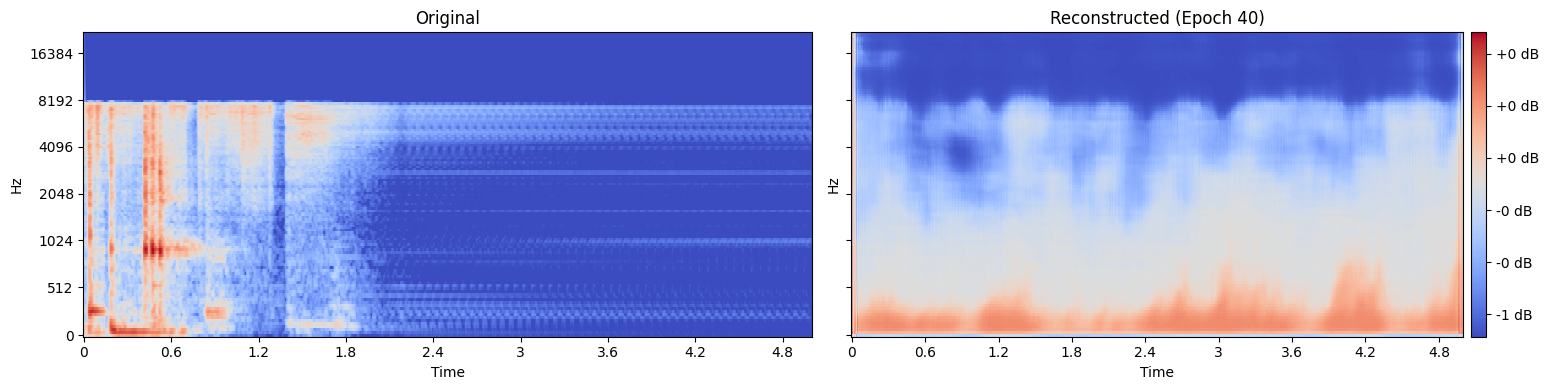

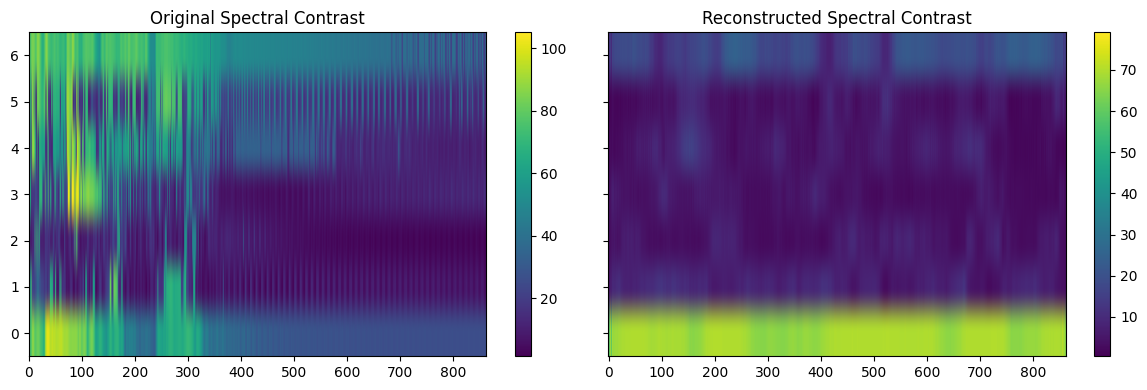

Epoch 41 | Loss=5.7344 | Recon=1.1863 | KL=5.1376 | z.std=1.0000 | Beta=0.731 | Smooth=0.0990 | MS=0.9021 | Contrast=0.4624
Epoch 42 | Loss=5.8336 | Recon=1.1922 | KL=5.1317 | z.std=1.0000 | Beta=0.750 | Smooth=0.0991 | MS=0.9064 | Contrast=0.4592
Epoch 43 | Loss=5.9166 | Recon=1.1819 | KL=5.1349 | z.std=1.0000 | Beta=0.769 | Smooth=0.0989 | MS=0.8987 | Contrast=0.4617
Epoch 44 | Loss=5.9999 | Recon=1.1794 | KL=5.1333 | z.std=1.0000 | Beta=0.786 | Smooth=0.0987 | MS=0.8953 | Contrast=0.4598
Epoch 45 | Loss=6.0803 | Recon=1.1786 | KL=5.1320 | z.std=1.0001 | Beta=0.802 | Smooth=0.0985 | MS=0.8960 | Contrast=0.4568
Epoch 46 | Loss=6.1530 | Recon=1.1752 | KL=5.1311 | z.std=1.0000 | Beta=0.818 | Smooth=0.0986 | MS=0.8922 | Contrast=0.4548
Epoch 47 | Loss=6.2159 | Recon=1.1674 | KL=5.1297 | z.std=1.0000 | Beta=0.832 | Smooth=0.0985 | MS=0.8866 | Contrast=0.4571
Epoch 48 | Loss=6.2887 | Recon=1.1691 | KL=5.1335 | z.std=1.0000 | Beta=0.846 | Smooth=0.0983 | MS=0.8872 | Contrast=0.4557
Epoch 49

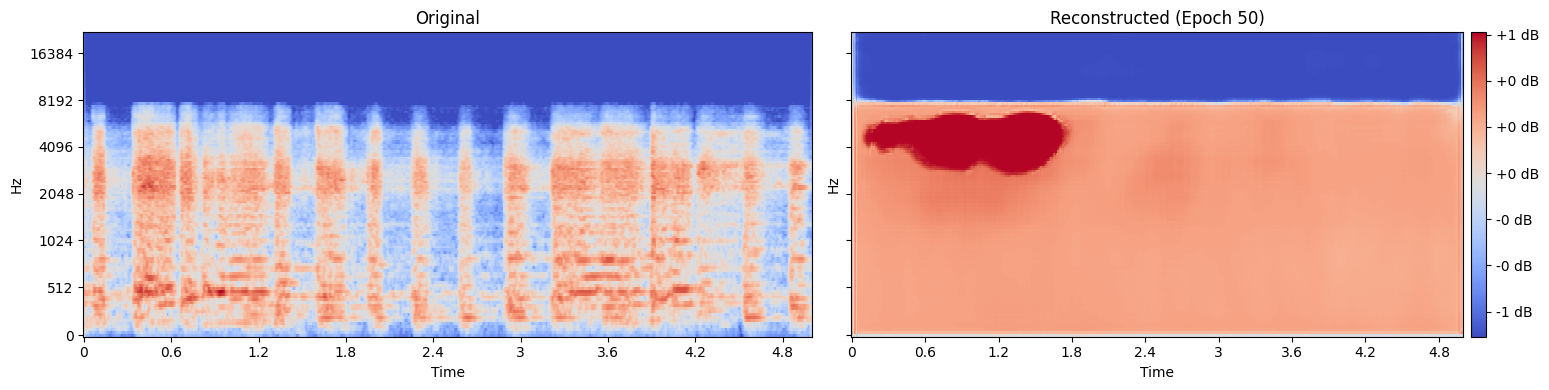

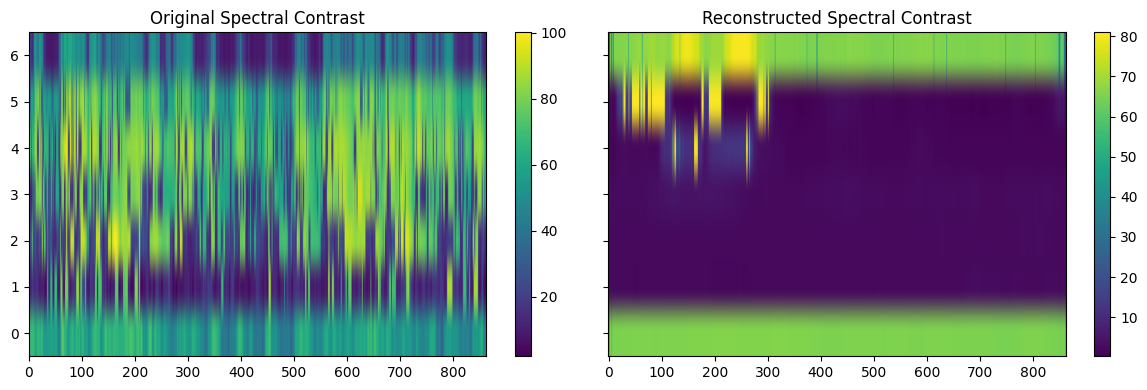

Epoch 51 | Loss=6.4516 | Recon=1.1593 | KL=5.1301 | z.std=1.0000 | Beta=0.881 | Smooth=0.0981 | MS=0.8791 | Contrast=0.4536
Epoch 52 | Loss=6.4829 | Recon=1.1428 | KL=5.1300 | z.std=1.0001 | Beta=0.891 | Smooth=0.0980 | MS=0.8672 | Contrast=0.4500
Epoch 53 | Loss=6.5364 | Recon=1.1486 | KL=5.1297 | z.std=1.0000 | Beta=0.900 | Smooth=0.0978 | MS=0.8720 | Contrast=0.4525
Epoch 54 | Loss=6.5695 | Recon=1.1413 | KL=5.1285 | z.std=1.0000 | Beta=0.909 | Smooth=0.0979 | MS=0.8653 | Contrast=0.4507
Epoch 55 | Loss=6.5969 | Recon=1.1307 | KL=5.1282 | z.std=1.0001 | Beta=0.917 | Smooth=0.0977 | MS=0.8586 | Contrast=0.4488
Epoch 56 | Loss=6.6519 | Recon=1.1458 | KL=5.1300 | z.std=1.0000 | Beta=0.924 | Smooth=0.0976 | MS=0.8677 | Contrast=0.4483
Epoch 57 | Loss=6.6648 | Recon=1.1293 | KL=5.1286 | z.std=1.0000 | Beta=0.931 | Smooth=0.0974 | MS=0.8559 | Contrast=0.4477
Epoch 58 | Loss=6.7247 | Recon=1.1530 | KL=5.1309 | z.std=1.0000 | Beta=0.937 | Smooth=0.0976 | MS=0.8712 | Contrast=0.4477
Epoch 59

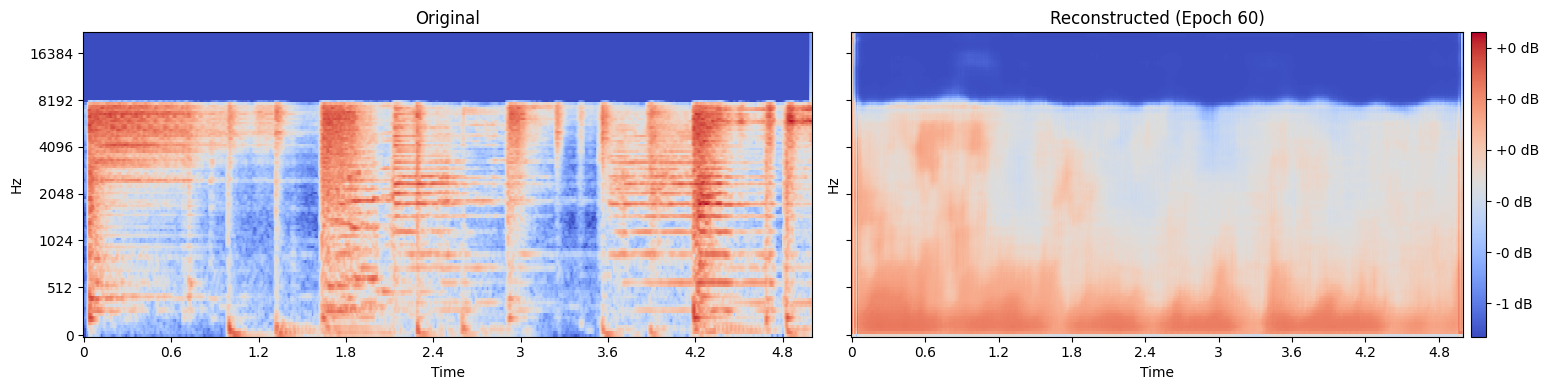

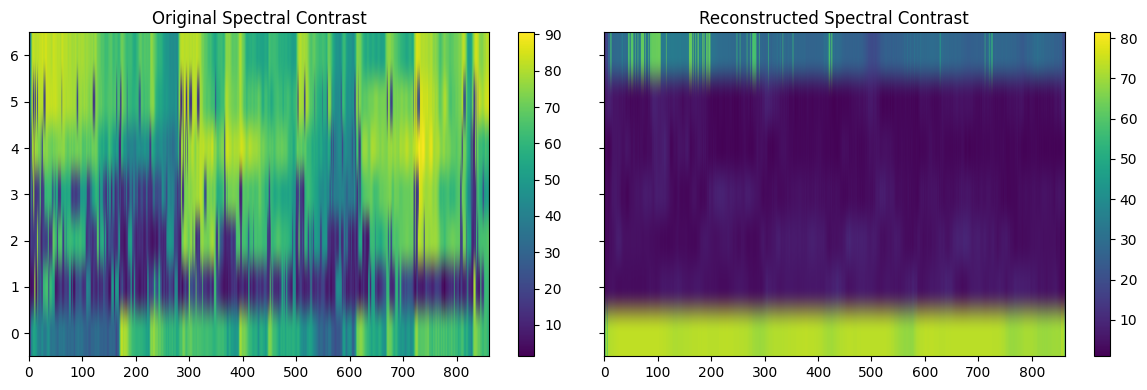

Epoch 61 | Loss=6.7658 | Recon=1.1247 | KL=5.1277 | z.std=1.0000 | Beta=0.953 | Smooth=0.0974 | MS=0.8511 | Contrast=0.4454
Epoch 62 | Loss=6.7940 | Recon=1.1311 | KL=5.1282 | z.std=1.0000 | Beta=0.957 | Smooth=0.0972 | MS=0.8537 | Contrast=0.4441
Epoch 63 | Loss=6.8093 | Recon=1.1251 | KL=5.1308 | z.std=1.0001 | Beta=0.961 | Smooth=0.0971 | MS=0.8508 | Contrast=0.4435
Epoch 64 | Loss=6.8234 | Recon=1.1246 | KL=5.1279 | z.std=1.0000 | Beta=0.964 | Smooth=0.0971 | MS=0.8502 | Contrast=0.4429
Epoch 65 | Loss=6.8301 | Recon=1.1171 | KL=5.1272 | z.std=1.0000 | Beta=0.968 | Smooth=0.0972 | MS=0.8436 | Contrast=0.4470
Epoch 66 | Loss=6.8491 | Recon=1.1207 | KL=5.1283 | z.std=1.0000 | Beta=0.971 | Smooth=0.0970 | MS=0.8461 | Contrast=0.4392
Epoch 67 | Loss=6.8768 | Recon=1.1337 | KL=5.1280 | z.std=1.0000 | Beta=0.973 | Smooth=0.0972 | MS=0.8551 | Contrast=0.4424
Epoch 68 | Loss=6.8696 | Recon=1.1177 | KL=5.1279 | z.std=1.0000 | Beta=0.976 | Smooth=0.0972 | MS=0.8437 | Contrast=0.4416
Epoch 69

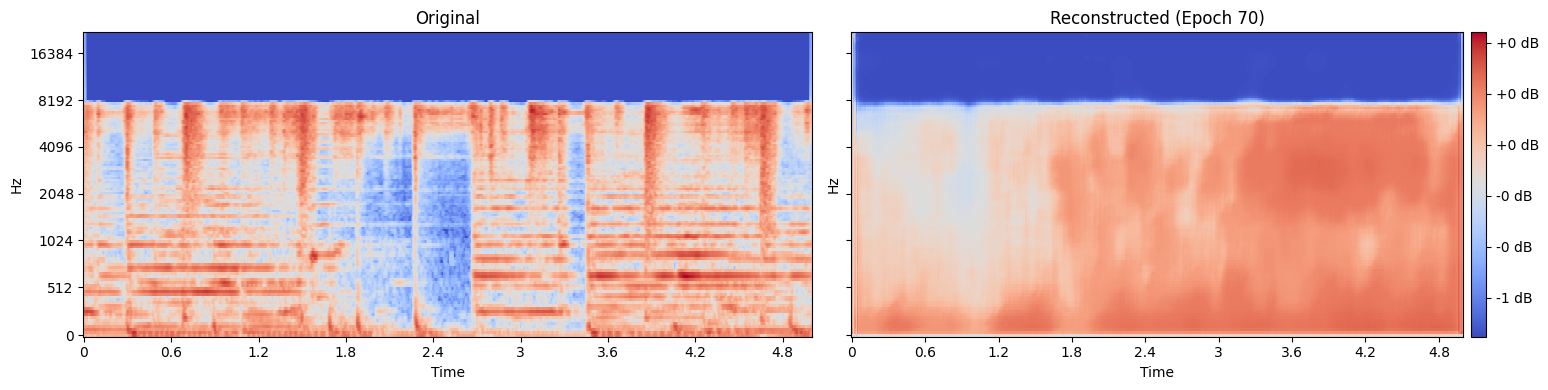

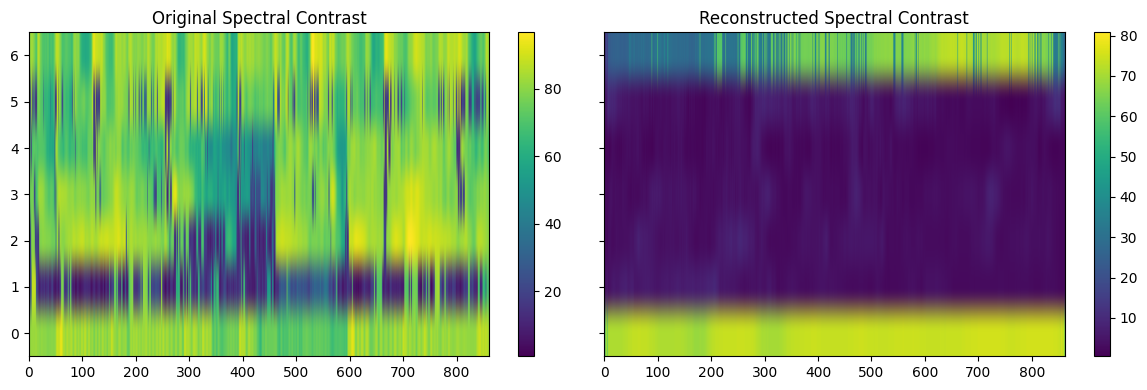

In [7]:
# === Get Actual Input Size from Dataset ===
sample_batch = next(iter(train_loader))  # returns a Tensor: [B, 1, mel_bins, T]
mel_tensor = sample_batch  # not a dict anymore
mel_dim, time_dim = mel_tensor.shape[-2], mel_tensor.shape[-1]
print(f"Input mel shape: {mel_dim} x {time_dim}")

# === Create VAE Model with Correct Input Shape ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

torch.cuda.empty_cache()
model = VAE(input_dim=(mel_dim, time_dim), latent_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# === Training Loop ===
num_epochs = 70
initial_lambda_smooth = 0.5
lambda_smooth_min = 0.05  # don't decay all the way to zero

z_std_history = []

lambda_multiscale = 0.1  # added hyperparameter

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    total_smooth = 0
    total_ms = 0
    total_contrast = 0  # NEW

    # === KL beta schedule
    if epoch < 10:
        beta = 0.001
    elif epoch < 20:
        beta = 0.05
    elif epoch < 30:
        beta = 0.2
    else:
        beta = min(1.0, 1 / (1 + np.exp(-0.1 * (epoch - 30))))


    # === Smoothing decay schedule
    if epoch < 30:
        lambda_smooth = initial_lambda_smooth
    else:
        lambda_smooth = max(lambda_smooth_min, initial_lambda_smooth * np.exp(-0.03 * (epoch - 30)))

    z_std_epoch = []

    for batch in train_loader:
        x_batch = batch.to(device)

        x_recon, mu, logvar = model(x_batch)
        loss, recon, kl, smooth, ms, contrast = vae_loss(
            x_recon, x_batch, mu, logvar,
            model=model,  # <-- must be passed in
            beta=beta,
            free_bits=0.01,
            lambda_smooth=lambda_smooth,
            lambda_multiscale=lambda_multiscale,
            lambda_contrast=0.05
        )


        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0:
            print("NaN batch detected")
            print(" → recon:", recon.item())
            print(" → kl:", kl.item())
            print(" → smooth:", smooth.item())
            print(" → ms:", ms.item())
            print(" → contrast:", contrast.item())
            continue


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        total_smooth += smooth.item()
        total_ms += ms.item()
        total_contrast += contrast.item()  # NEW

        with torch.no_grad():
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            z = z / z.std(dim=1, keepdim=True).clamp(min=1e-6)  # ✅ normalize latent
            z_std_epoch.append(z.std().item())

            if z.std().item() < 0.01:
                print(f"⚠️ Warning: z.std too small at epoch {epoch+1}: {z.std().item():.5f}")


    # === Logging per epoch
    avg_z_std = np.mean(z_std_epoch)
    z_std_history.append(avg_z_std)

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    avg_smooth = total_smooth / len(train_loader)
    avg_ms = total_ms / len(train_loader)
    avg_contrast = total_contrast / len(train_loader)  # NEW

    print(f"Epoch {epoch+1:02d} | Loss={avg_loss:.4f} | Recon={avg_recon:.4f} | KL={avg_kl:.4f} | "
      f"z.std={avg_z_std:.4f} | Beta={beta:.3f} | Smooth={avg_smooth:.4f} | MS={avg_ms:.4f} | "
      f"Contrast={avg_contrast:.4f}")


    torch.cuda.empty_cache()

    # === Visualization
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            batch = next(iter(train_loader))
            x_val = batch.to(device) if isinstance(batch, torch.Tensor) else batch['mel'].to(device)

            x_recon, _, _ = model(x_val)

            mel_orig = x_val[0].squeeze().cpu().numpy()        # shape: [128, T]
            mel_recon = x_recon[0].squeeze().cpu().numpy()     # shape: [128, T]
            print(f"Original: {mel_orig.shape}, Recon: {mel_recon.shape}")

            # === Plot mel spectrograms
            fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
            img1 = librosa.display.specshow(mel_orig, sr=44100, hop_length=256, ax=axs[0], x_axis='time', y_axis='mel')
            axs[0].set_title("Original")

            img2 = librosa.display.specshow(mel_recon, sr=44100, hop_length=256, ax=axs[1], x_axis='time', y_axis='mel')
            axs[1].set_title(f"Reconstructed (Epoch {epoch+1})")

            fig.colorbar(img2, ax=axs[1], format="%+2.0f dB", orientation='vertical', pad=0.01)
            plt.tight_layout()
            plt.show()

            # === Plot contrast maps (normalized → linear power → linear freq)
            plot_contrast_maps(mel_orig, mel_recon)  # pass normalized [-1, 1] arrays directly


🎵 Reconstructing 5 clips from real data


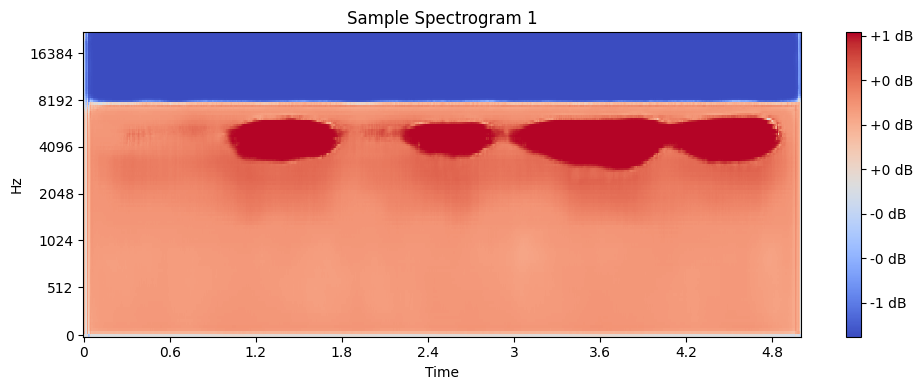

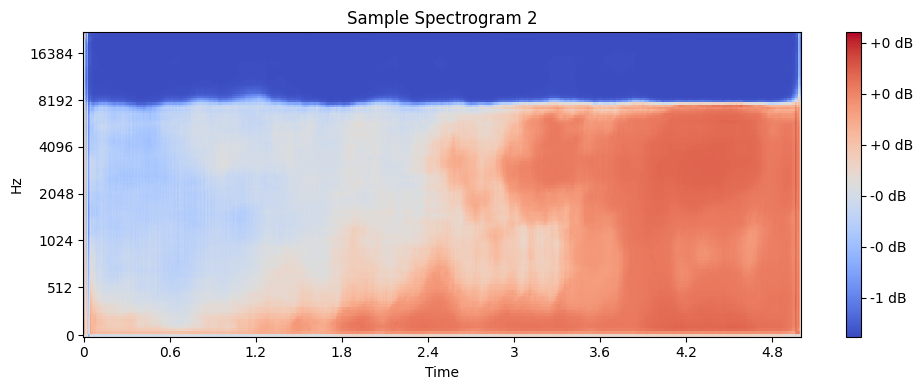

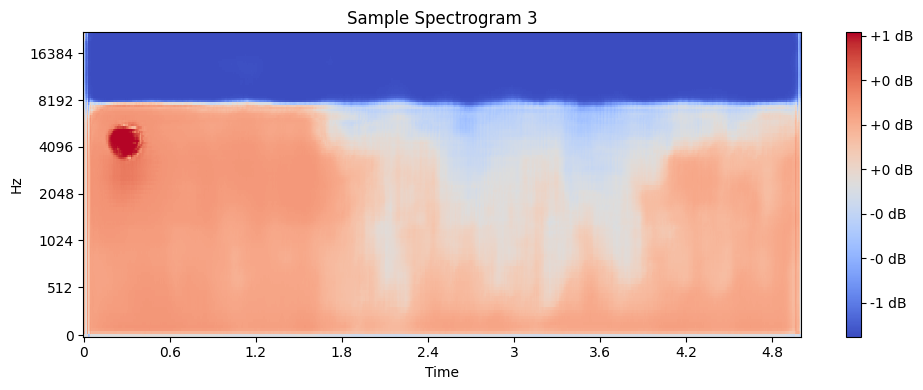

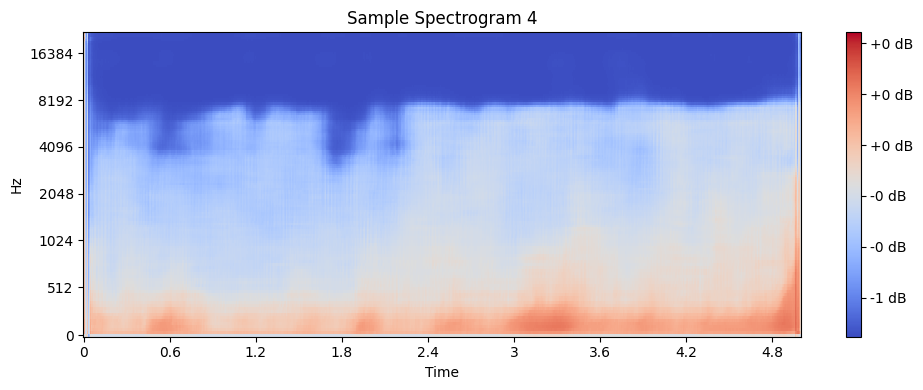

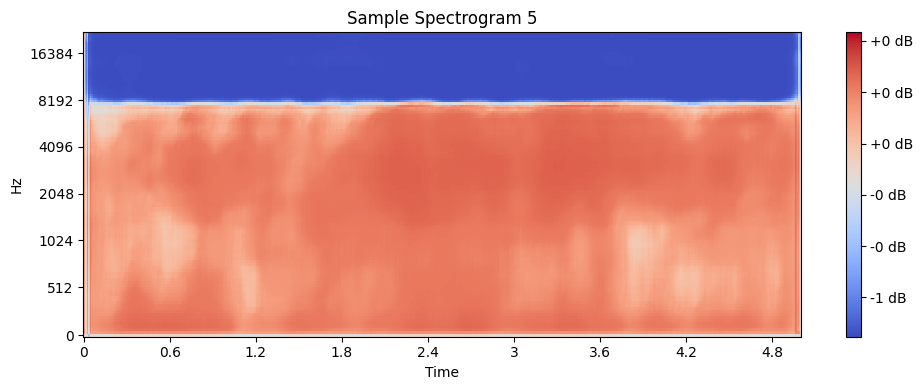

✅ Exported continuous_unconditioned.mp3 — duration: 50.0 seconds


In [8]:
def plot_mel_output(mel, sr=44100, title="Mel Output"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=sr, hop_length=256, y_axis='mel', x_axis='time')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def generate_audio_sample(
    model,
    train_loader,
    sr=44100,
    n_samples=5,  # default clip count
    sample_mode="recon",  # or "random"
    plot=True,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    hop_length = 512
    os.makedirs("temp_clips", exist_ok=True)
    audio_clips = []

    # === Get latent vectors
    with torch.no_grad():
        batch = next(iter(train_loader)).to(device)
        mu, logvar = model.encode(batch)

        if sample_mode == "random":
            z_all = torch.randn_like(mu)
            print(f"🎲 Sampling {n_samples} clips from prior N(0,1)")
        else:
            z_all = model.reparameterize(mu, logvar)
            print(f"🎵 Reconstructing {n_samples} clips from real data")

    n_samples = min(n_samples, z_all.size(0))

    for i in range(n_samples):
        z = z_all[i].unsqueeze(0)

        with torch.no_grad():
            mel_out = model.decode(z).cpu().squeeze().numpy()

        # === Plot (optional)
        if plot:
            plot_mel_output(mel_out, sr=sr, title=f"Sample Spectrogram {i+1}")

        # === Rescale: [-1, 1] → [-80, 0] dB
        mel_out = np.clip(mel_out, -1.0, 1.0)
        mel_db = mel_out * 40.0  # [-1, 1] → [-40, 40]
        mel_db = np.clip(mel_db, -80.0, 0.0)

        # === dB to linear power
        mel_power = librosa.db_to_power(mel_db)

        # === Griffin-Lim to waveform
        audio = librosa.feature.inverse.mel_to_audio(
            mel_power,
            sr=sr,
            n_fft=1024,
            hop_length=hop_length,
            win_length=1024,
            n_iter=60,
            fmax=8000  # ← this fixes the empty filter warning
        )


        # === Save clip
        temp_path = f"temp_clips/clip_{i}.wav"
        sf.write(temp_path, audio, sr)
        audio_clips.append(AudioSegment.from_wav(temp_path))

    # === Combine clips and export final audio
    final_audio = sum(audio_clips)
    final_audio.export("continuous_unconditioned.mp3", format="mp3")
    print(f"✅ Exported continuous_unconditioned.mp3 — duration: {final_audio.duration_seconds:.1f} seconds")


generate_audio_sample(model, train_loader, n_samples=5, sample_mode="recon")

